Check Python environment

In [1]:
import sys
sys.executable


'C:\\Users\\Alex\\anaconda3\\envs\\PythonProjects\\python.exe'

In [22]:
!pip list

Package                   Version
------------------------- ------------
aiofiles                  22.1.0
aiohttp                   3.9.1
aiosignal                 1.3.1
aiosqlite                 0.18.0
anyio                     3.5.0
argon2-cffi               21.3.0
argon2-cffi-bindings      21.2.0
astor                     0.8.1
asttokens                 2.0.5
async-lru                 2.0.4
attrs                     23.1.0
autograd                  1.6.2
autograd-gamma            0.5.0
Babel                     2.11.0
backcall                  0.2.0
beautifulsoup4            4.12.2
bleach                    4.1.0
Bottleneck                1.3.5
Brotli                    1.0.9
certifi                   2023.11.17
cffi                      1.16.0
charset-normalizer        2.0.4
colorama                  0.4.6
comm                      0.1.2
contourpy                 1.2.0
cryptography              41.0.7
cycler                    0.11.0
debugpy                   1.6.7
decorator       

Importing packages

In [3]:
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as scipy

from sklearn.datasets import fetch_openml
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_tweedie_deviance,
)

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    KBinsDiscretizer,
    OneHotEncoder,
    StandardScaler,
)

Defining functions

In [4]:
def poisson_deviance(obs,est):
 return 2*(special.xlogy(obs,obs/est)-(obs-est))

Loading claims and exposure data

In [5]:
def load_claim_data(n_samples=None):
    # freMTPL2sev dataset from https://www.openml.org/d/41215
    df_sev = fetch_openml(data_id=41215, as_frame=True, parser="pandas").data
    df_sev["IDpol"] = df_sev["IDpol"].astype('int')
    df_sev=df_sev.sort_values("IDpol")
    return df_sev.iloc[:n_samples]
    

In [6]:
def load_expo_data(n_samples=None):
    # freMTPL2freq dataset from https://www.openml.org/d/41214
    df_freq = fetch_openml(data_id=41214, as_frame=True, parser="pandas").data
    df_freq["IDpol"] = df_freq["IDpol"].astype('int')
    df_freq = df_freq.sort_values("IDpol")
    return df_freq.iloc[:n_samples]

In [7]:
claim_data = load_claim_data()

In [8]:
claim_data


,IDpol,ClaimAmount
2966,139,303.00
2839,190,1981.84
1354,414,1456.55
2164,424,9844.36
689,424,989.64
...,...,...
2659,6113793,1769.88
2551,6113817,1288.28
2665,6113834,1940.40
2664,6113834,10290.00


In [9]:
expo_data = load_expo_data()

In [10]:
expo_data

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1,1,0.10000,D,5,0,55,50,B12,'Regular',1217,R82
1,3,1,0.77000,D,5,0,55,50,B12,'Regular',1217,R82
2,5,1,0.75000,B,6,2,52,50,B12,'Diesel',54,R22
3,10,1,0.09000,B,7,0,46,50,B12,'Diesel',76,R72
4,11,1,0.84000,B,7,0,46,50,B12,'Diesel',76,R72
...,...,...,...,...,...,...,...,...,...,...,...,...
678008,6114326,0,0.00274,E,4,0,54,50,B12,'Regular',3317,R93
678009,6114327,0,0.00274,E,4,0,41,95,B12,'Regular',9850,R11
678010,6114328,0,0.00274,D,6,2,45,50,B12,'Diesel',1323,R82
678011,6114329,0,0.00274,B,4,0,60,50,B12,'Regular',95,R26


i) Merge claims data onto exposure data, so have data on individual claims with covariates
ii) Restricting to all no-null claims. I.e claims where claimsize>0

In [11]:
claim_data = pd.merge(expo_data,claim_data,on = "IDpol",how='left')
claim_data=claim_data[claim_data['ClaimAmount']>0]
claim_data['ClaimAmount']=np.round(claim_data['ClaimAmount'],0)
claim_data['ClaimAmount']=claim_data['ClaimAmount'].astype('int')

In [12]:
columns_to_remove = ['ClaimNb']
claim_data = claim_data.drop(columns=columns_to_remove)
claim_data

,IDpol,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount
66,139,0.75,F,7,1,61,50,B12,'Regular',27000,R11,303
93,190,0.14,B,12,5,50,60,B12,'Diesel',56,R25,1982
199,414,0.14,E,4,0,36,85,B12,'Regular',4792,R11,1457
205,424,0.62,F,10,0,51,100,B12,'Regular',27000,R11,9844
206,424,0.62,F,10,0,51,100,B12,'Regular',27000,R11,990
...,...,...,...,...,...,...,...,...,...,...,...,...
678974,6113793,0.14,C,7,2,51,50,B12,'Diesel',178,R72,1770
678998,6113817,0.17,D,4,0,35,51,B12,'Regular',1719,R82,1288
679015,6113834,0.17,C,15,3,36,50,B12,'Regular',181,R54,1940
679016,6113834,0.17,C,15,3,36,50,B12,'Regular',181,R54,10290


Defining number of (non-null) claims based on (non-null) claims data

In [13]:
number_of_claims = pd.DataFrame(claim_data.groupby('IDpol').agg({'IDpol':'first','ClaimAmount':'count'})).reset_index(drop=True)
number_of_claims = number_of_claims.rename(columns= {'ClaimAmount':'N'})
number_of_claims
                                           



,IDpol,N
0,139,1
1,190,1
2,414,1
3,424,2
4,463,1
...,...,...
24939,6113521,1
24940,6113793,1
24941,6113817,1
24942,6113834,2


Merging number of claims and IDpol onto exposure data so to be able to model claims frequency 


In [14]:
expo_data = pd.merge(expo_data,number_of_claims,how="left", on = 'IDpol')
expo_data['N'] = expo_data['N'].fillna(0)
expo_data['N']=expo_data['N'].astype('int')
expo_data
columns_to_remove = ['ClaimNb']
expo_data = expo_data.drop(columns=columns_to_remove)

In [15]:
expo_data

,IDpol,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,N
0,1,0.10000,D,5,0,55,50,B12,'Regular',1217,R82,0
1,3,0.77000,D,5,0,55,50,B12,'Regular',1217,R82,0
2,5,0.75000,B,6,2,52,50,B12,'Diesel',54,R22,0
3,10,0.09000,B,7,0,46,50,B12,'Diesel',76,R72,0
4,11,0.84000,B,7,0,46,50,B12,'Diesel',76,R72,0
...,...,...,...,...,...,...,...,...,...,...,...,...
678008,6114326,0.00274,E,4,0,54,50,B12,'Regular',3317,R93,0
678009,6114327,0.00274,E,4,0,41,95,B12,'Regular',9850,R11,0
678010,6114328,0.00274,D,6,2,45,50,B12,'Diesel',1323,R82,0
678011,6114329,0.00274,B,4,0,60,50,B12,'Regular',95,R26,0


In [16]:
condition = expo_data['N'] > 0
selected_rows = expo_data[condition]
selected_rows

,IDpol,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,N
66,139,0.75,F,7,1,61,50,B12,'Regular',27000,R11,1
93,190,0.14,B,12,5,50,60,B12,'Diesel',56,R25,1
199,414,0.14,E,4,0,36,85,B12,'Regular',4792,R11,1
205,424,0.62,F,10,0,51,100,B12,'Regular',27000,R11,2
223,463,0.31,A,5,0,45,50,B12,'Regular',12,R73,1
...,...,...,...,...,...,...,...,...,...,...,...,...
677203,6113521,0.18,C,4,1,26,60,B12,'Diesel',311,R82,1
677475,6113793,0.14,C,7,2,51,50,B12,'Diesel',178,R72,1
677499,6113817,0.17,D,4,0,35,51,B12,'Regular',1719,R82,1
677516,6113834,0.17,C,15,3,36,50,B12,'Regular',181,R54,2


Priliminary check of Poisson assumption for claims frequency. Inspired by  https://github.com/lorentzenchr/Tutorial_freMTPL2/blob/master/glm_freMTPL2_example.ipynb

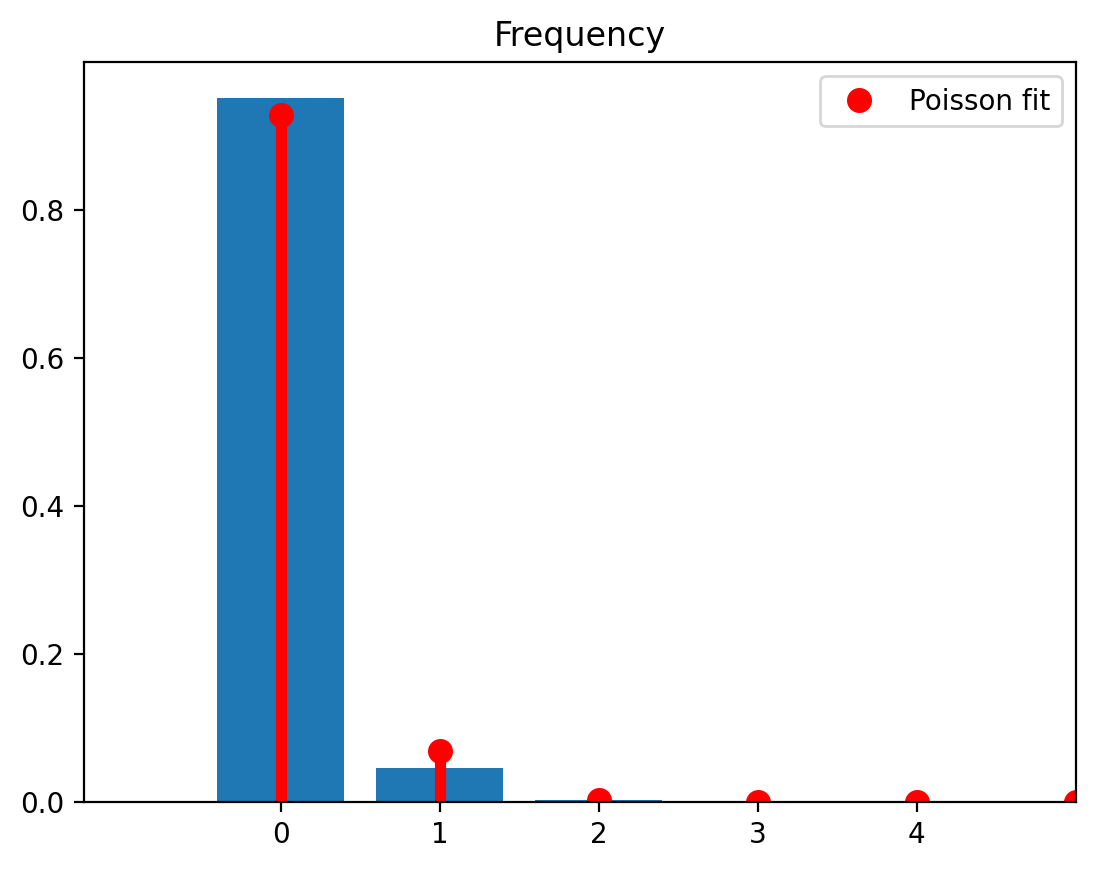

,N,Observed_frequency,Estimated_frequency
0,0,0.951805,0.928892
1,1,0.045529,0.068518
2,2,0.002536,0.002527
3,3,0.000118,0.000062
4,4,0.000006,0.000001
5,5,0.000003,0.000000
6,6,0.000001,0.000000
7,8,0.000001,0.000000
8,9,0.000000,0.000000
9,11,0.000000,0.000000


In [20]:
pd.set_option('display.float_format', lambda x: '%.6f' % x)
claim_prop=expo_data.groupby("N").agg(Observed_frequency=('Exposure', lambda x: sum(x) / sum(expo_data['Exposure']))
                                     ).reset_index()
mean = expo_data['N'].sum() / expo_data['Exposure'].sum()
claim_prop['Estimated_frequency'] = scipy.stats.poisson.pmf(claim_prop['N'], mean)
#claim_count['N']=claim_count['N'].astype('category')
fig, ax = plt.subplots()
ax.bar(claim_prop['N'],claim_prop['Observed_frequency'])
ax.axis(xmax=5)


x = range(5)
plt.plot(claim_prop['N'], claim_prop['Estimated_frequency'], 'ro', ms=8, mec='r', label='Poisson fit')
plt.vlines(x=x, ymin=0, ymax=scipy.stats.poisson.pmf(x, mean), color='r', lw=4)
plt.xticks(x)
plt.legend()
plt.title("Frequency");
plt.show()

claim_prop

Now we visualize the data

C:\Users\Alex\AppData\Local\Temp\ipykernel_12928\3915323235.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  var_freq = expo_data.groupby(by=variable).agg(
C:\Users\Alex\AppData\Local\Temp\ipykernel_12928\3915323235.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  var_freq = expo_data.groupby(by=variable).agg(
C:\Users\Alex\AppData\Local\Temp\ipykernel_12928\3915323235.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warni

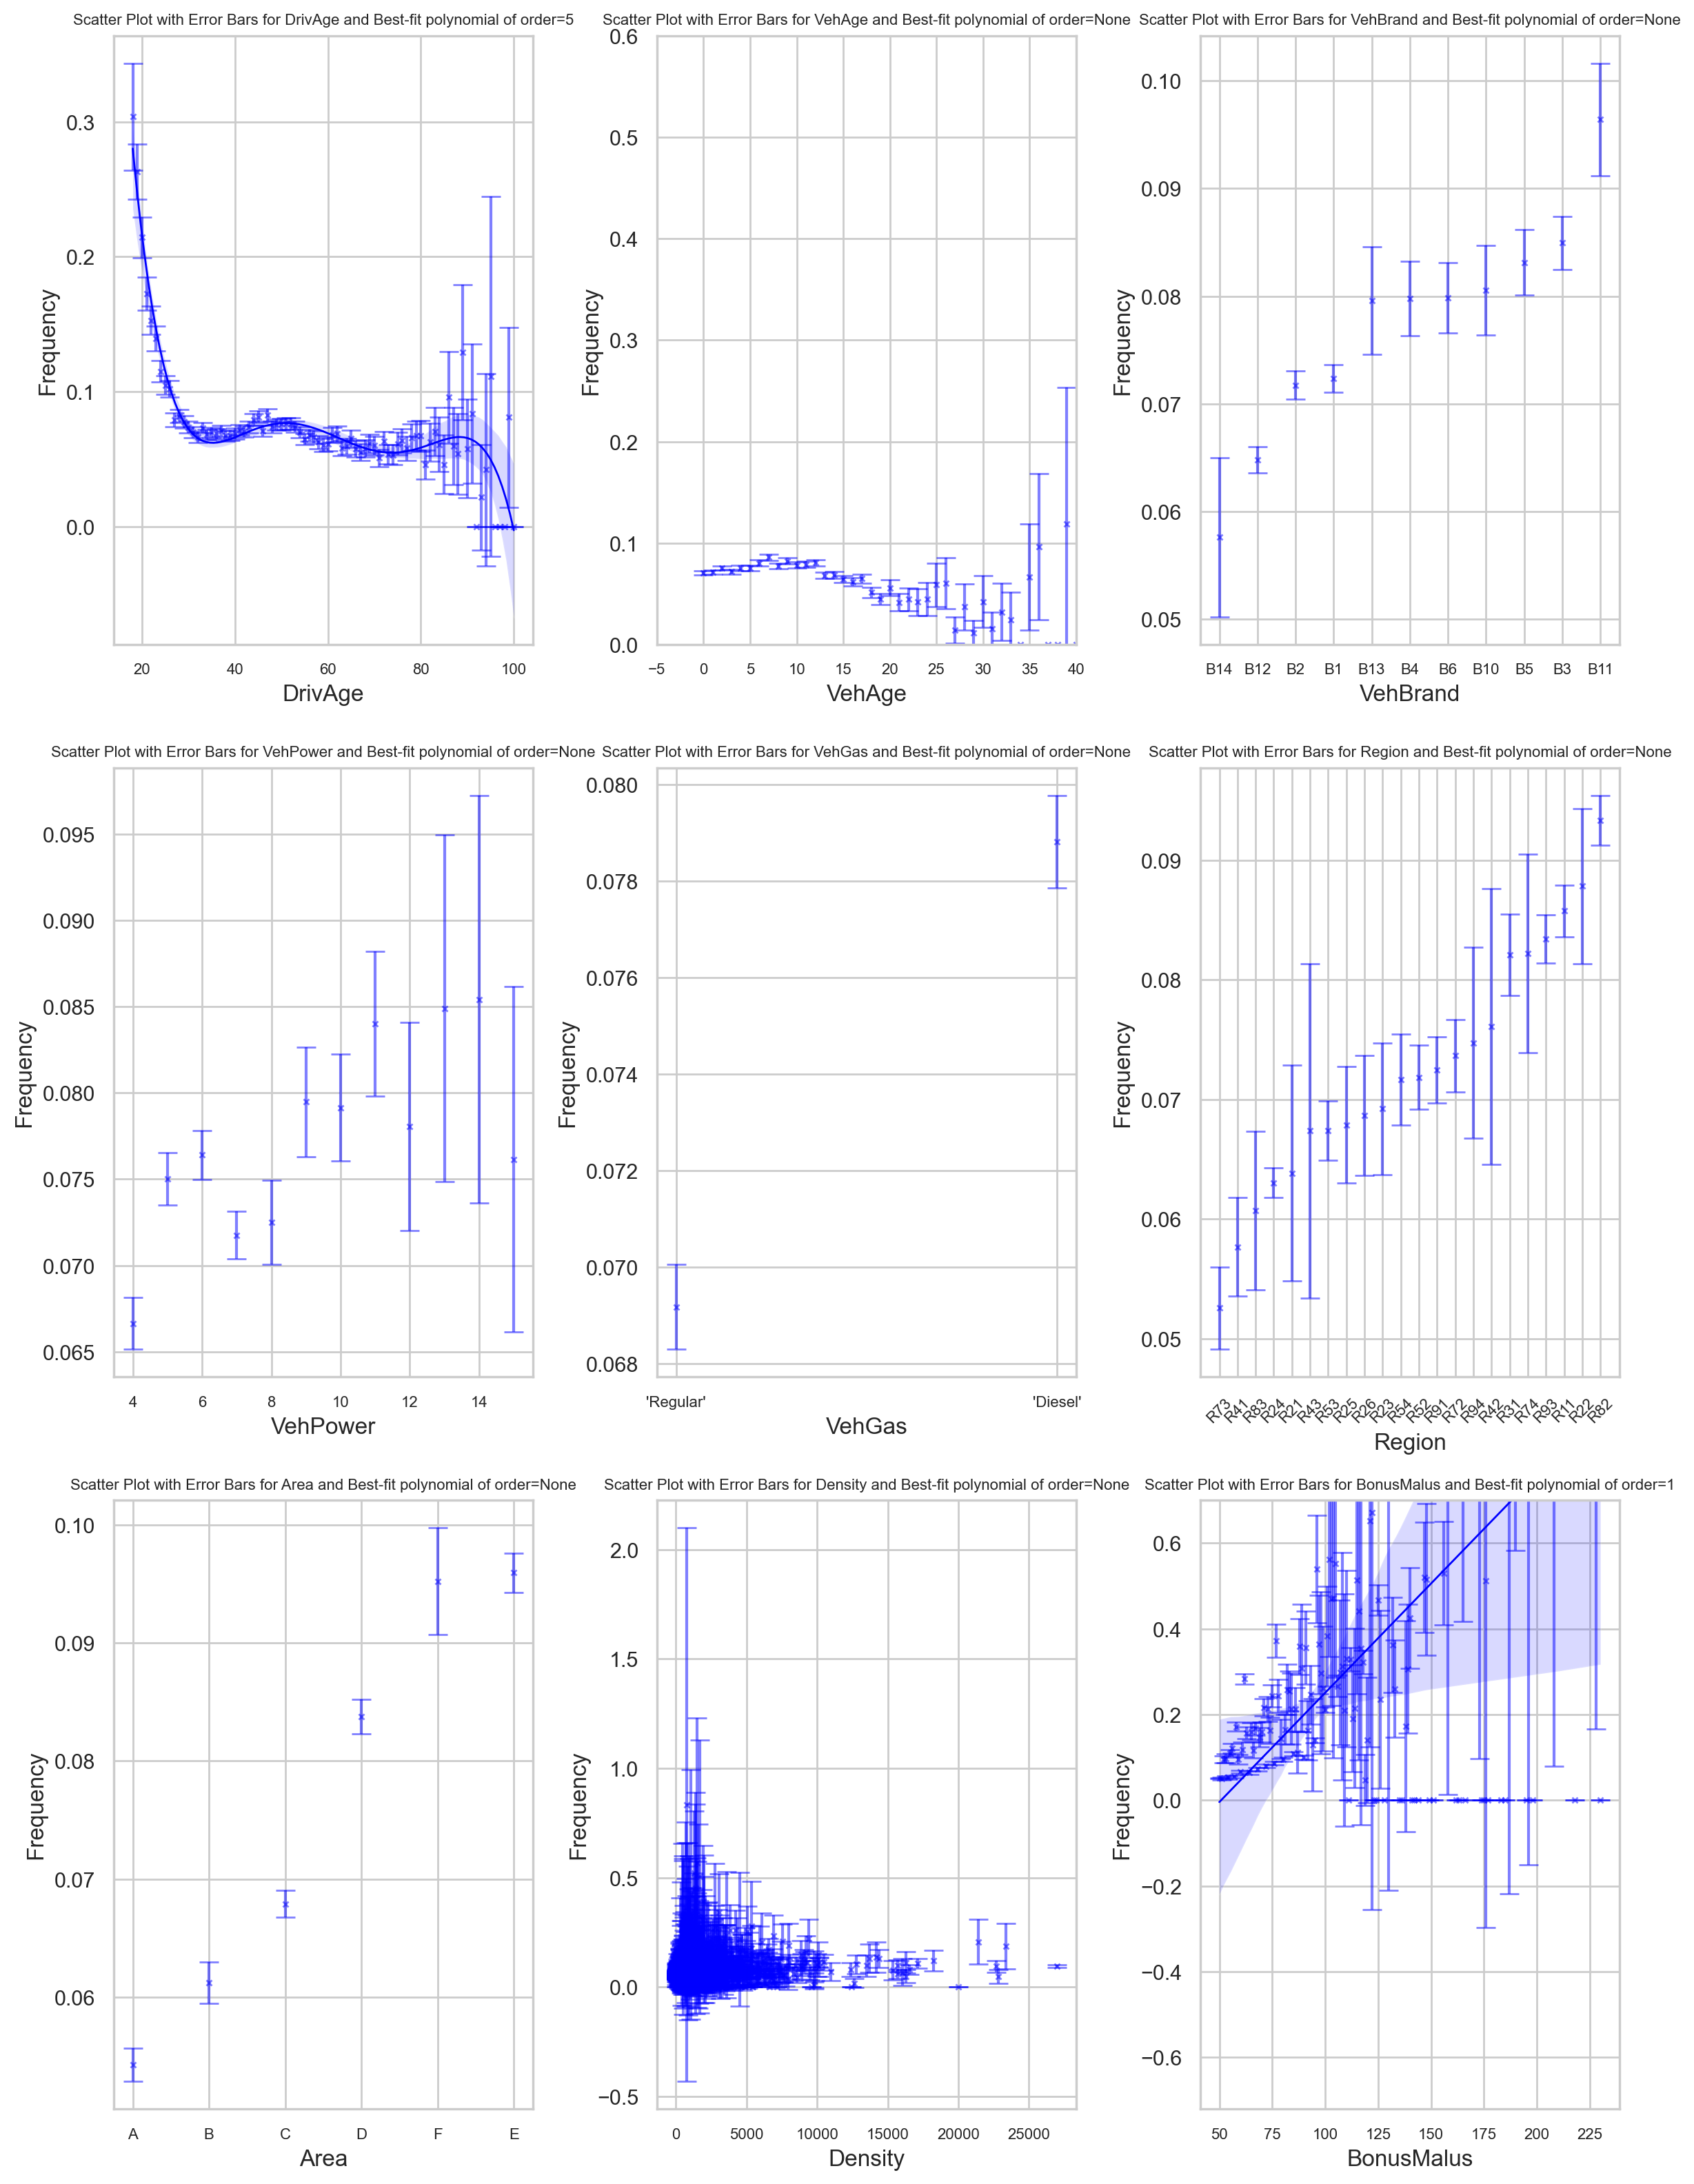

In [49]:
import seaborn as sns
sns.set(style="whitegrid")

fig, axes = plt.subplots(3, 3, figsize=(12, 16))
axes = axes.flatten()

def uni(variable, poly=True, order=None, xmax=None, ymin=None, ymax=None, sort=None, ax=None,rotation=None):
    var_freq = expo_data.groupby(by=variable).agg(
        N=('N', 'sum'),
        Exposure=('Exposure', 'sum'),
        Frequency=('N', lambda x: sum(x) / sum(expo_data.loc[x.index, 'Exposure'])),
        std_err=('N', lambda x: 1.96 * np.sqrt(sum(x) / sum(expo_data.loc[x.index, 'Exposure']) / len(expo_data.loc[x.index, 'Exposure'])))
    ).reset_index()
    
    if sort:
        var_freq = var_freq.sort_values(by='Frequency')

    if ax is None:
        _, ax = plt.subplots()

    ax.errorbar(var_freq[variable], var_freq['Frequency'], yerr=var_freq['std_err'], fmt='x', capsize=5, alpha=0.5, color='blue', markersize=3)
    if poly:
        sns.regplot(x=var_freq[variable], y=var_freq['Frequency'], scatter=False, order=order,
                    line_kws={'color': 'blue', 'label': 'Polynomial best fit ', 'linewidth': 1}, ax=ax)

    ax.set_xlabel(variable)
    ax.set_ylabel('Frequency')
    ax.set_title(f'Scatter Plot with Error Bars for {variable} and Best-fit polynomial of order={order}',fontsize=8)

    ax.axis(ymin=ymin, ymax=ymax, xmax=xmax)

    # Change x-axis label size
    ax.tick_params(axis='x', labelsize=8,rotation=rotation)

# Call the uni function for each variable
uni('DrivAge', poly=True, order=5, ax=axes[0])
uni('VehAge', poly=False, xmax=40, ymax=0.6, ymin=0, ax=axes[1])
uni('VehBrand', poly=False, sort=True, ax=axes[2])
uni('VehPower', poly=False, sort=True, ax=axes[3])
uni('VehGas', poly=False, sort=True, ax=axes[4])
uni('Region', poly=False, sort=True, ax=axes[5],rotation=45)
uni('Area', poly=False, sort=True, ax=axes[6])
uni('Density', poly=False, sort=True, ax=axes[7])
uni('BonusMalus', poly=True,order=1, sort=True,ymax=0.7, ax=axes[8])

plt.tight_layout()
plt.show()




Frequency modelling:

In [ ]:
Checking the type of each variable

In [50]:
expo_data.dtypes

IDpol            int32
Exposure       float64
Area          category
VehPower         int64
VehAge           int64
DrivAge          int64
BonusMalus       int64
VehBrand      category
VehGas          object
Density          int64
Region        category
N                int32
dtype: object

In [ ]:
Changing type of variables

In [69]:
expo_data = expo_data.astype({'Exposure':'int64','VehGas':'category'})
VehPower_val = pd.DataFrame(expo_data['VehPower'].unique(), columns=['VehPower'])
VehPower_val = VehPower_val.sort_values(by='VehPower')
VehPower_val = VehPower_val['VehPower']
values
    

3      4
0      5
1      6
2      7
6      8
4      9
7     10
9     11
8     12
11    13
10    14
5     15
Name: VehPower, dtype: int64

In [ ]:
Preprocessing pipe

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.Pipeline import Pipeline
from sklearn.model_selection import train_test_split

preprocessor = ColumnTransformer([
        (
            "binned_numeric",
            KBinsDiscretizer(n_bins=10, subsample=int(2e5), random_state=0),
            ["VehAge", "DrivAge"],
        ),
        ("log_scaled_numeric", log_scale_transformer, ["Density"]),
        (
            "onehot_categorical",
            OneHotEncoder(),
            ["VehBrand", "VehPower", "VehGas", "Region", "Area"],
        ),
    ],
    remainder="passthrough",
)





